In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Preliminary Analysis of Features

Loading the data

In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out= pd.read_csv(loc,**kwargs)
    return out

import urllib
def getLargeFile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        url = gdrive
        urllib.request.urlretrieve(gdrive, loc)
        out= pd.read_csv(loc,**kwargs)
    return out

fname = ("Crime_Data_from_2020_to_Present.csv", 
         "https://drive.google.com/u/0/uc?id=1WwLkX_BADtPY83rFQ4CQ5Lbf6UcI055A&export=download&confirm=t&uuid=4e0aae58-2f5b-4420-941f-8f2f49ae0cb8&at=ALAFpqzX_FrSz-hUtqhaXe2ui7h6:1667673013562")
df = getLargeFile(fname)
df.head()

local file not found; accessing Google Drive


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [ ]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [ ]:
for column in df.columns.values:
    print(f'{column} with {df[column].unique().shape[0]} unique values')

DR_NO with 590832 unique values
Date Rptd with 1028 unique values
DATE OCC with 1028 unique values
TIME OCC with 1439 unique values
AREA with 21 unique values
AREA NAME with 21 unique values
Rpt Dist No with 1189 unique values
Part 1-2 with 2 unique values
Crm Cd with 137 unique values
Crm Cd Desc with 137 unique values
Mocodes with 208301 unique values
Vict Age with 101 unique values
Vict Sex with 5 unique values
Vict Descent with 20 unique values
Premis Cd with 310 unique values
Premis Desc with 307 unique values
Weapon Used Cd with 79 unique values
Weapon Desc with 79 unique values
Status with 5 unique values
Status Desc with 5 unique values
Crm Cd 1 with 140 unique values
Crm Cd 2 with 121 unique values
Crm Cd 3 with 36 unique values
Crm Cd 4 with 7 unique values
LOCATION with 59096 unique values
Cross Street with 8687 unique values
LAT with 5352 unique values
LON with 4949 unique values


## Consolidating and Examining the Dates of Crimes

We first convert the dates to datetime objects, shown below

In [ ]:
df['Date Rptd'] = df['Date Rptd'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['DATE OCC'] = df['DATE OCC'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

We can take a look at which days of the week most crimes occurred

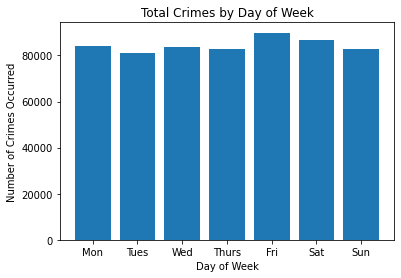

In [ ]:
plt.bar(df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, df['DATE OCC'].dt.day_of_week.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes Occurred')
plt.title('Total Crimes by Day of Week')
plt.show()
plt.close()

Shown above, most crimes take place during the start of the weekend

We can also take a look at which months most crimes occurred

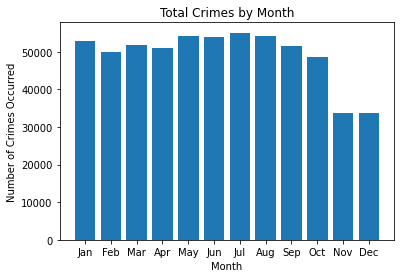

In [ ]:
plt.bar(df['DATE OCC'].dt.month.value_counts().sort_index().index, df['DATE OCC'].dt.month.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.month.value_counts().sort_index().index, \
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Total Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

Evidently, crime occurs more over the summer and the start of the year

## Examining Crime Categories

We can look at the top 10 crime categories

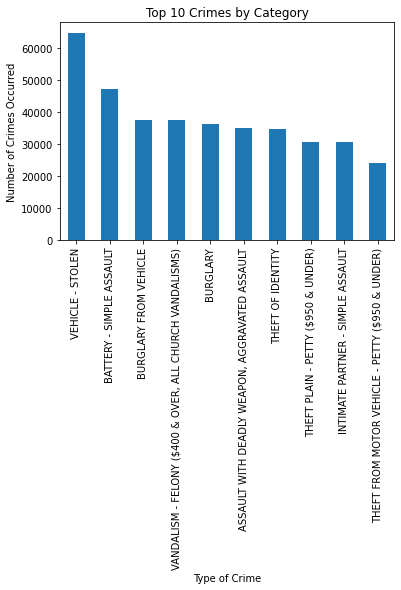

In [ ]:
df['Crm Cd Desc'].value_counts()[:10].plot(kind = 'bar')
plt.xlabel('Type of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Top 10 Crimes by Category')
plt.show()
plt.close()

## Crime Evolution Over Time

Since the ultimate task of this project involves a Recurrent Neural Network with a time component, it is in our interest to obtain a preliminary idea of how crime evolves over time

### Total Crimes Over Time

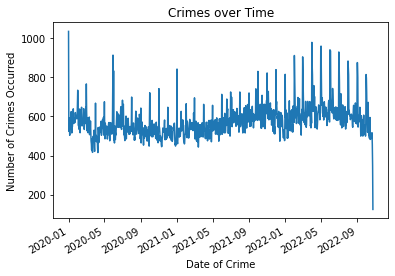

In [ ]:
plt.plot(df['DATE OCC'].value_counts().sort_index().index, df['DATE OCC'].value_counts().sort_index())
plt.xlabel('Date of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Crimes over Time')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

### Crimes Occurred over Years, Grouped by Month

We must first format the data such that it can be used

In [ ]:
df['Month OCC'] = df['DATE OCC'].dt.month
df['Year OCC'] = df['DATE OCC'].dt.year
month_year_occ = [str(m)+"/"+str(y) for m,y in zip(df["Month OCC"], df["Year OCC"])]
month_year_occ_formatted = [dt.datetime.strptime(d, "%m/%Y") for d in month_year_occ]
df["Month Year OCC"] = np.array(month_year_occ_formatted)

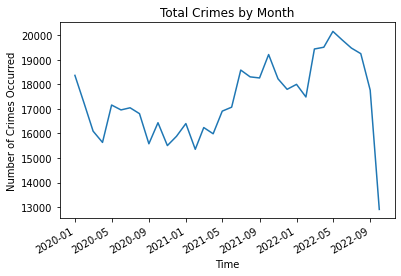

In [ ]:
plt.plot(df["Month Year OCC"].value_counts().sort_index().index, df["Month Year OCC"].value_counts().sort_index())
plt.gcf().autofmt_xdate()
plt.title('Total Crimes by Month')
plt.xlabel('Time')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

### Crimes by Time of Day

We first define a few functions to read the military time format

In [ ]:
# convert into 4-char strings
def makemil(time):
    ntime = ""
    if len(str(time)) == 1:
        ntime = "000" + str(time)
    if len(str(time)) == 2:
        ntime = "00" + str(time)
    if len(str(time)) == 3:
        ntime = "0" + str(time)
    if len(str(time)) == 4:
        ntime = str(time)
    return ntime

# function for retrieving the hour of the time
def returnhour(miltime):
    return miltime[:2]

In [ ]:
df["TIME OCC"] = df["TIME OCC"].apply(makemil)

Plotting the number of crimes by time of day

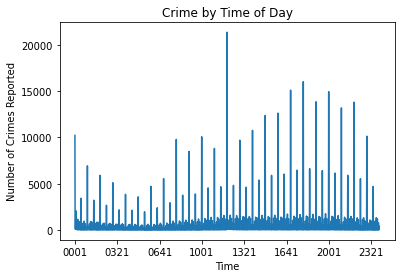

In [ ]:
df['TIME OCC'].value_counts().apply(int).sort_index().plot()
plt.xlabel('Time')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by Time of Day')
plt.show()
plt.close()

We see that most crimes occur around midnight, which will be a key observation for our RNN

### Crimes by the Hour

In [ ]:
df['Hour OCC'] =  df["TIME OCC"].apply(returnhour)

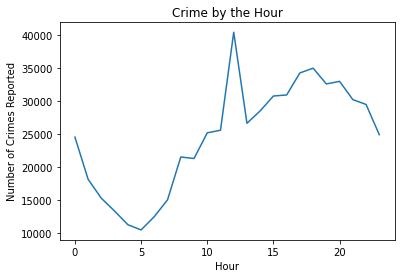

In [ ]:
df['Hour OCC'].apply(int).value_counts().apply(int).sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by the Hour')
plt.show()
plt.close()

Plotting the number of crimes reported against the hour of the day confirms our hypothesis above

### Dropping Unnecessary Columns

In [ ]:
# df.drop(columns = 'DR_NO', inplace = True) # DR number is all unique

# should we drop date rpt as well as we are solely intrested in the occurence of crimes?

## Deep Learning Method - Regression Model

### Model

* For this task, a 3-layer full-connected deep network will be applied to perform the same regression task as the linear regression model in the benchmark.

* Formula

For features: $x = [x_1, ...., x_n]$, target

$$y = \phi_3(M_3D_3B\phi_2(M_2D_2B\phi_1(M_1 x + b_1) + b_2) + b_3)$$

where $\phi_i$ are activation functions, $D_i$ are dropout matrices, $B$ is the batch normalization layer.

* Loss Function

Mean square error is applied for loss function.

$$\mathcal{L}(Y, Y') = \frac{1}{\|\mathcal{D_{train}}\|} \sum_{y\in Y}(y - y')^2$$



In [ ]:
class DeepRegressionModel(torch.nn.Module):
  def __init__(self, input_dims, hidden_dims, dropout_rate = 0.3, device = None):
    super(DeepRegressionModel, self).__init__()
    self.fc1 = torch.nn.Linear(input_dims, hidden_dims)
    self.fc2 = torch.nn.Linear(hidden_dims, hidden_dims//2)
    self.fc3 = torch.nn.Linear(hidden_dims//2, 1)

    self.bn1 = torch.nn.BatchNorm1d(hidden_dims)
    self.bn2 = torch.nn.BatchNorm1d(hidden_dims//2)

    self.dropout2 = torch.nn.Dropout(p=dropout_rate)
    self.dropout3 = torch.nn.Dropout(p=dropout_rate)

    self.loss_fn = torch.nn.MSELoss()
    self.opt = None

    self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  def forward(self, x):
    x = self.fc1(x)
    x = torch.sigmoid(x)
    x = self.bn1(x)
    x = self.dropout2(x,)

    x = self.fc2(x)
    x = torch.tanh(x)
    x = self.bn2(x)
    x = self.dropout3(x)

    x = self.fc3(x)
    x = torch.relu(x)
    return x
  
  def metrics(self, y_pred, y):
    return torch.mean(torch.abs(y - y_pred)).cpu().detach().numpy()

  def train_model(self, x_train, y_train, num_epoch = 10, batch_size=64, learning_rate = 1e-3, optimizer_type=torch.optim.SGD):
    if self.opt is None:
      self.opt = optimizer_type(self.parameters(), lr=learning_rate)

    tensor_x = torch.Tensor(x_train).to(torch.float32).to(self.device)
    tensor_y = torch.Tensor(y_train.reshape(-1, 1)).to(torch.float32).to(self.device)

    train_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_size = len(train_dataloader.dataset)

    num_iter_per_epoch = x_train.shape[0] // batch_size + 1
    losses = []
    self.train()
    for e in range(num_epoch+1):
      losses_epoch = []

      for batch, (X, y) in enumerate(train_dataloader):

        pred = self.forward(X)
        loss = self.loss_fn(pred, y)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        losses_epoch.append(loss.cpu().detach().numpy())
      losses.append(np.mean(losses_epoch))
      if e % (num_epoch // 10) == 0:
        print(f"Epoch {e:02d}: loss - {losses[-1]:.5f}")
      
    return losses

  def test(self, x_test, y_test, batch_size=64):
    tensor_x = torch.Tensor(x_test).to(self.device)
    tensor_y = torch.Tensor(y_test.reshape(-1, 1)).to(self.device)

    test_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_size = len(test_dataloader.dataset)

    metric = 0
    self.eval()

    with torch.no_grad():
      for X, y in test_dataloader:
        y_pred = self.forward(X)
        metric_batch = self.metrics(y_pred, y)
        metric += metric_batch * y_pred.shape[0]

    return metric / test_size

### Problem  Description

* Purpose: From the initial analysis, we find that `Month/Year`, `Latitude/Longitude`, `Victim Sex`, and `Victim Age` are some of important features that affects the number of crimes. Therefore, by using this linear regression model, we want to discuss the relation between these features and the number of crimes.
* Features:
  * Scalar Features:
    * Victim Age
    * Latitude
    * Longitude

  * Categorical Features:
    * Victim Sex (F, M, X, H)
    * Month (1 to 12)
    * Year (2020, 2021, 2022)

* Target: Given a specific month (`Month` + `Year`) , a specific region (`Lat` + `Lon`), predict **the number of crimes** happend on a specific group of people (`Vict Age` + `Vict Sex`) within that month in that region.
* Problem Type: supervised learning + regression

In [ ]:
class Utils:
  def __init__(self):
    pass

  @classmethod
  def one_hot_encoding(cls, categories, data) -> np.ndarray:
    """
    Args:
      categories: [Nc, ]
      data: [N, ]
    Returns:
      result: [N, Nc]
    """
    sorted_categories = sorted(categories)

    category_map = {c: i for i, c in enumerate(sorted_categories)}

    ids = np.array(list(map(lambda c: category_map[c], data)))
   
    result = np.zeros((data.shape[0], len(categories)))

    result[np.arange(ids.size), ids] = 1

    return result


### Dataset Preparation

* Group the dataset by feature set, get the number of crimes for each group

In [ ]:
df['Count'] = np.ones(df.shape[0])
df.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Month OCC,Year OCC,Month Year OCC,Hour OCC,Count
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978,1,2020,2020-01-01,22,1.0
1,190101086,2020-01-02,2020-01-01,0330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,700 S HILL ST,NaN,34.0459,-118.2545,1,2020,2020-01-01,03,1.0
2,200110444,2020-04-14,2020-02-13,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,NaN,200 E 6TH ST,NaN,34.0448,-118.2474,2,2020,2020-02-01,12,1.0
3,191501505,2020-01-01,2020-01-01,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019,1,2020,2020-01-01,17,1.0
4,191921269,2020-01-01,2020-01-01,0415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,14400 TITUS ST,NaN,34.2198,-118.4468,1,2020,2020-01-01,04,1.0


In [ ]:
scalar_features = ['LAT', 'LON', 'Vict Age']
categorical_features = ['Year OCC', 'Month OCC', 'Vict Sex']
target_feature = ['Count']
source_features = scalar_features + categorical_features
all_features = source_features + target_feature

data = df[all_features].copy()
data = data.dropna()
data['LAT'] = data['LAT'].apply(lambda x: np.round(x, 2))
data['LON'] = data['LON'].apply(lambda x: np.round(x, 2))

data = data[(data.T != 0).all()]

In [ ]:
dataset = data.groupby(source_features).agg('sum').reset_index()
dataset = shuffle(dataset, random_state = 0)
dataset.head(5)
print(dataset.shape)

(372086, 7)


* Data preprocessing:
  * scalar feature: normalization
$$x_{norm} = \frac{x-\mu_x}{\sigma_x}$$
  * categorical feature: one-hot embedding

In [ ]:
# Encoding dataset
dataset_enc = []
feature_end_ids = []

# scalar features:
scalar_data = dataset[scalar_features].to_numpy()
scalar_mean = scalar_data.mean(axis=0)
scalar_std = scalar_data.std(axis=0)
scalar_norm = (scalar_data - scalar_mean) / scalar_std
dataset_enc.append(scalar_norm)
feature_end_ids.extend((np.arange(len(scalar_features)) + 1).tolist())

# categorial features:
categories = { c: dataset[c].unique() for c in categorical_features }

for c in categorical_features:
  dataset_enc.append(Utils.one_hot_encoding(categories[c], dataset[c].to_numpy()))
  if len(feature_end_ids) > 0:
    feature_end_ids.append(feature_end_ids[-1] + len(categories[c]))
  else:
    feature_end_ids.append([len(categories[c])])


dataset_enc = np.concatenate(dataset_enc, axis=1)
print(dataset_enc.shape)

labels = dataset[target_feature].to_numpy().flatten()
print(labels.shape)

(372086, 22)
(372086,)


### Model Training & Testing

* Train/Test Split
  * Training size: 60%
  * Validation size: 20%
  * Testing size: 20%

In [ ]:
num_rows, num_features = dataset_enc.shape

random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

test_size = 0.2
validation_size = 0.2

num_epoch = 100
learning_rate = .001
batch_size = 256

x_train_val, x_test, y_train_val, y_test = train_test_split(
    dataset_enc, labels, test_size=test_size, random_state=random_seed)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=validation_size / (1-test_size), random_state=random_seed)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(223251, 22)
(74417, 22)
(74418, 22)


* Training with default settings

In [ ]:
# train benchmark
torch.manual_seed(random_seed)
deep_reg_model = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=32)
deep_reg_model.to(deep_reg_model.device)
losses = deep_reg_model.train_model(
    x_train_val, y_train_val, num_epoch=num_epoch, 
    batch_size=batch_size, learning_rate=learning_rate)

Epoch 00: loss - 1.26154
Epoch 10: loss - 0.44236
Epoch 20: loss - 0.44177
Epoch 30: loss - 0.44182
Epoch 40: loss - 0.44133
Epoch 50: loss - 0.44120
Epoch 60: loss - 0.44109
Epoch 70: loss - 0.44091
Epoch 80: loss - 0.44091
Epoch 90: loss - 0.44054
Epoch 100: loss - 0.44062


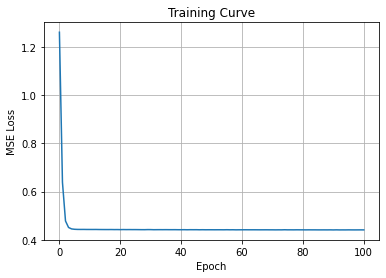

In [ ]:
plt.clf()
plt.plot(np.arange(len(losses)), losses)
plt.title("Training Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()
plt.close()

* Testing

In [ ]:
deep_reg_model.to(deep_reg_model.device)
metric = deep_reg_model.test(x_test, y_test, batch_size=batch_size)
print(f"Final metrics of deep regression model = {metric:.5f}")

Final metrics of deep regression model = 0.32987



###  Effects of mini-batch learning
In this part, we will force the optimizer as SGD, while changing the training batch size.

In [ ]:
# get batch candidates
min_batches = 64
max_batches = x_train.shape[0]

candidates = []
cur_batches = min_batches
while cur_batches < min(2049, max_batches):
  candidates.append(cur_batches)
  cur_batches *= 4
candidates.append(max_batches)

print("Batch Size for testing:")
print(candidates)

Batch Size for testing:
[64, 256, 1024, 223251]


In [ ]:
losses = []
metrics = []
models = []

for candidate in candidates:
  torch.manual_seed(random_seed)
  deep_reg_model_c = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=32)
  deep_reg_model_c.to(deep_reg_model_c.device)
  losses_c = deep_reg_model_c.train_model(
      x_train_val, y_train_val, num_epoch=num_epoch // 2, 
      batch_size=candidate, learning_rate=learning_rate)
  losses.append(losses_c)

  metric_c = deep_reg_model_c.test(x_test, y_test, batch_size=candidate)
  metrics.append(metric_c)
  models.append(deep_reg_model_c)
np.savetxt("effect_miniBatch_losses.npy", np.array(losses))
np.savetxt("effect_miniBatch_metrics.npy", np.array(metrics))

Epoch 00: loss - 0.70850
Epoch 05: loss - 0.44220
Epoch 10: loss - 0.44150
Epoch 15: loss - 0.44140
Epoch 20: loss - 0.44107
Epoch 25: loss - 0.44090
Epoch 30: loss - 0.44078
Epoch 35: loss - 0.44088
Epoch 40: loss - 0.44038
Epoch 45: loss - 0.44038
Epoch 50: loss - 0.44015
Epoch 00: loss - 1.26154
Epoch 05: loss - 0.44313
Epoch 10: loss - 0.44236
Epoch 15: loss - 0.44204
Epoch 20: loss - 0.44177
Epoch 25: loss - 0.44185
Epoch 30: loss - 0.44182
Epoch 35: loss - 0.44164
Epoch 40: loss - 0.44133
Epoch 45: loss - 0.44143
Epoch 50: loss - 0.44120
Epoch 00: loss - 1.49722
Epoch 05: loss - 0.65180
Epoch 10: loss - 0.46886
Epoch 15: loss - 0.44690
Epoch 20: loss - 0.44329
Epoch 25: loss - 0.44252
Epoch 30: loss - 0.44278
Epoch 35: loss - 0.44263
Epoch 40: loss - 0.44213
Epoch 45: loss - 0.44234
Epoch 50: loss - 0.44220
Epoch 00: loss - 1.55801
Epoch 05: loss - 1.62695
Epoch 10: loss - 1.67535
Epoch 15: loss - 1.59092
Epoch 20: loss - 1.52529
Epoch 25: loss - 1.52412
Epoch 30: loss - 1.51635


[0.32969179 0.32913819 0.33179455 1.02397537]


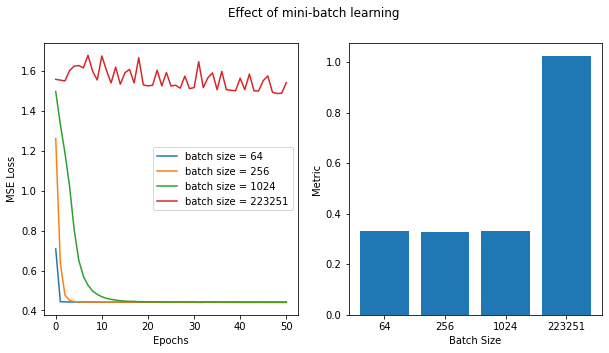

In [ ]:
# Plot the effect
losses = np.loadtxt("effect_miniBatch_losses.npy")
metrics = np.loadtxt("effect_miniBatch_metrics.npy")
print(metrics)
epochs = np.arange(losses.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for (i, candidate) in enumerate(candidates):
  loss_data = losses[i]
  metric_data = metrics[i]
  axes[0].plot(epochs, loss_data, label=f"batch size = {candidate:d}")

axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")

xticks = np.arange(len(metrics))
axes[1].bar(xticks, metrics)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(candidates)
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Metric")
fig.suptitle("Effect of mini-batch learning")
plt.show()

### Effects of different optimizers

In this part, we will force the batch size to be 256, while changing the type of optimizer. All optimizer use the same initial learning rate.

In [ ]:
optimizer_types = {"SGD": torch.optim.SGD, "Adam": torch.optim.Adam, "RMSprop": torch.optim.RMSprop}

In [ ]:
losses = []
metrics = []
models = []

for (optimizer_type, optimizer_class) in optimizer_types.items():
  torch.manual_seed(random_seed)
  deep_reg_model_c = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=32)
  deep_reg_model_c.to(deep_reg_model_c.device)
  losses_c = deep_reg_model_c.train_model(
      x_train_val, y_train_val, num_epoch=num_epoch // 2, 
      batch_size=256, learning_rate=learning_rate, optimizer_type = optimizer_class)
  losses.append(losses_c)

  metric_c = deep_reg_model_c.test(x_test, y_test, batch_size=256)
  metrics.append(metric_c)
  models.append(deep_reg_model_c)
np.savetxt("effect_optimizer_losses.npy", np.array(losses))
np.savetxt("effect_optimizer_metrics.npy", np.array(metrics))

Epoch 00: loss - 1.26154
Epoch 05: loss - 0.44313
Epoch 10: loss - 0.44236
Epoch 15: loss - 0.44204
Epoch 20: loss - 0.44177
Epoch 25: loss - 0.44185
Epoch 30: loss - 0.44182
Epoch 35: loss - 0.44164
Epoch 40: loss - 0.44133
Epoch 45: loss - 0.44143
Epoch 50: loss - 0.44120
Epoch 00: loss - 0.66826
Epoch 05: loss - 0.43232
Epoch 10: loss - 0.42821
Epoch 15: loss - 0.42657
Epoch 20: loss - 0.42499
Epoch 25: loss - 0.42330
Epoch 30: loss - 0.42291
Epoch 35: loss - 0.42135
Epoch 40: loss - 0.42019
Epoch 45: loss - 0.41995
Epoch 50: loss - 0.41957
Epoch 00: loss - 0.93154
Epoch 05: loss - 0.43009
Epoch 10: loss - 0.42853
Epoch 15: loss - 0.42767
Epoch 20: loss - 0.42612
Epoch 25: loss - 0.42509
Epoch 30: loss - 0.42354
Epoch 35: loss - 0.42304
Epoch 40: loss - 0.42234
Epoch 45: loss - 0.42196
Epoch 50: loss - 0.42115


[0.32913819 0.30719107 0.30593919]


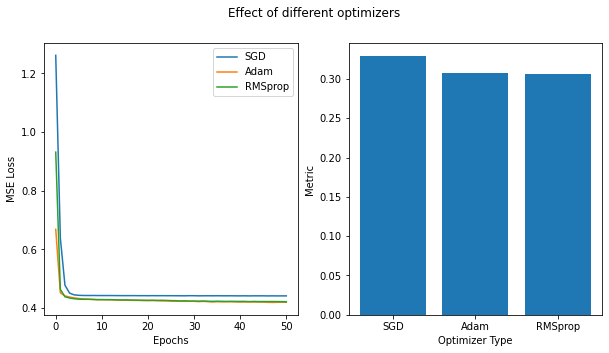

In [ ]:
# Plot the effect
losses = np.loadtxt("effect_optimizer_losses.npy")
metrics = np.loadtxt("effect_optimizer_metrics.npy")
epochs = np.arange(losses.shape[1])

print(metrics)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for (i, optimizer_type) in enumerate(optimizer_types):
  loss_data = losses[i]
  metric_data = metrics[i]
  axes[0].plot(epochs, loss_data, label=optimizer_type)

axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")

xticks = np.arange(metrics.shape[0])
axes[1].bar(xticks, metrics)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(list(optimizer_types.keys()))
axes[1].set_xlabel("Optimizer Type")
axes[1].set_ylabel("Metric")
fig.suptitle("Effect of different optimizers")
plt.show()

### Hyperparameter Tuning (Training, Testing and Validation)

Given the fact above, `batch size = 256` and `optimizer = RMSprop` are selected.

For hyperparameter tuning, there are two sets of parameters to choose from:

1. Hidden layer dimensions:  [32, 64, 128]

2. Dropout rate: [0.0, 0.1, 0.2]

In [ ]:
opt_batch_size = 256
opt_optimizer = torch.optim.RMSprop

In [ ]:
# Hidden Layer Dimensions

hidden_layer_dims = [32, 64, 128]

metrics = []
for hidden_layer_dim in hidden_layer_dims:
  torch.manual_seed(random_seed)
  deep_reg_model_c = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=hidden_layer_dim, dropout_rate=0.0)
  deep_reg_model_c.to(deep_reg_model_c.device)
  _ = deep_reg_model_c.train_model(
      x_train, y_train, num_epoch=num_epoch // 2, 
      batch_size=opt_batch_size, learning_rate=learning_rate, optimizer_type = opt_optimizer)

  metric_c = deep_reg_model_c.test(x_val, y_val, batch_size=opt_batch_size)
  metrics.append(metric_c)

  print(metric_c)

print(f"Hidden Layer Dimensions: {hidden_layer_dims}")
print(f"Metrics on validation set: {metrics}")

opt_id = np.argmin(metrics)
opt_hidden_layer_dim = hidden_layer_dims[opt_id]
print(f"Optimal hidden layer dimension: {opt_hidden_layer_dim}")

Epoch 00: loss - 0.90300
Epoch 05: loss - 0.39737
Epoch 10: loss - 0.39039
Epoch 15: loss - 0.38715
Epoch 20: loss - 0.38543
Epoch 25: loss - 0.38376
Epoch 30: loss - 0.38194
Epoch 35: loss - 0.37976
Epoch 40: loss - 0.37884
Epoch 45: loss - 0.37596
Epoch 50: loss - 0.37517
0.2886909301734604
Epoch 00: loss - 0.58745
Epoch 05: loss - 0.39343
Epoch 10: loss - 0.38829
Epoch 15: loss - 0.38532
Epoch 20: loss - 0.38318
Epoch 25: loss - 0.38085
Epoch 30: loss - 0.37863
Epoch 35: loss - 0.37744
Epoch 40: loss - 0.37574
Epoch 45: loss - 0.37244
Epoch 50: loss - 0.37304
0.2882528542664928
Epoch 00: loss - 0.81125
Epoch 05: loss - 0.38955
Epoch 10: loss - 0.38377
Epoch 15: loss - 0.38149
Epoch 20: loss - 0.37943
Epoch 25: loss - 0.37783
Epoch 30: loss - 0.37485
Epoch 35: loss - 0.37354
Epoch 40: loss - 0.37225
Epoch 45: loss - 0.37328
Epoch 50: loss - 0.36963
0.30606731534619347
Hidden Layer Dimensions: [32, 64, 128]
Metrics on validation set: [0.2886909301734604, 0.2882528542664928, 0.30606731

In [ ]:
# Dropout rate

dropout_rates = [0.0, 0.1, 0.2]

metrics = []
for dropout_rate in dropout_rates:
  torch.manual_seed(random_seed)
  deep_reg_model_c = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=opt_hidden_layer_dim, dropout_rate=dropout_rate)
  deep_reg_model_c.to(deep_reg_model_c.device)
  _ = deep_reg_model_c.train_model(
      x_train, y_train, num_epoch=num_epoch // 2, 
      batch_size=opt_batch_size, learning_rate=learning_rate, optimizer_type = opt_optimizer)

  metric_c = deep_reg_model_c.test(x_val, y_val, batch_size=opt_batch_size)
  metrics.append(metric_c)
  print(metric_c)

print(f"Dropout Rates: {dropout_rates}")
print(f"Metrics on validation set: {metrics}")

opt_id = np.argmin(metrics)
opt_dropout_rate = dropout_rates[opt_id]
print(f"Optimal dropout rate: {opt_dropout_rate}")

Epoch 00: loss - 0.58745
Epoch 05: loss - 0.39343
Epoch 10: loss - 0.38829
Epoch 15: loss - 0.38532
Epoch 20: loss - 0.38318
Epoch 25: loss - 0.38085
Epoch 30: loss - 0.37863
Epoch 35: loss - 0.37744
Epoch 40: loss - 0.37574
Epoch 45: loss - 0.37244
Epoch 50: loss - 0.37304
0.2882528542664928
Epoch 00: loss - 0.51459
Epoch 05: loss - 0.40000
Epoch 10: loss - 0.39737
Epoch 15: loss - 0.39449
Epoch 20: loss - 0.39319
Epoch 25: loss - 0.39094
Epoch 30: loss - 0.38951
Epoch 35: loss - 0.38923
Epoch 40: loss - 0.38876
Epoch 45: loss - 0.38702
Epoch 50: loss - 0.38711
0.29530558354027964
Epoch 00: loss - 0.83451
Epoch 05: loss - 0.40293
Epoch 10: loss - 0.40000
Epoch 15: loss - 0.39805
Epoch 20: loss - 0.39706
Epoch 25: loss - 0.39562
Epoch 30: loss - 0.39487
Epoch 35: loss - 0.39417
Epoch 40: loss - 0.39304
Epoch 45: loss - 0.39232
Epoch 50: loss - 0.39231
0.29670043916148137
Dropout Rates: [0.0, 0.1, 0.2]
Metrics on validation set: [0.2882528542664928, 0.29530558354027964, 0.29670043916148

### Train optimal model with optimal settings and test the model on test set

In [ ]:
torch.manual_seed(random_seed)
opt_model = DeepRegressionModel(input_dims=x_train.shape[1], hidden_dims=opt_hidden_layer_dim, dropout_rate=opt_dropout_rate)
opt_model.to(opt_model.device)
_ = opt_model.train_model(
      x_train_val, y_train_val, num_epoch=num_epoch, 
      batch_size=opt_batch_size, learning_rate=learning_rate, optimizer_type = opt_optimizer)

Epoch 00: loss - 0.92000
Epoch 10: loss - 0.40450
Epoch 20: loss - 0.40035
Epoch 30: loss - 0.39550
Epoch 40: loss - 0.39343
Epoch 50: loss - 0.39263
Epoch 60: loss - 0.39014
Epoch 70: loss - 0.38790
Epoch 80: loss - 0.38732
Epoch 90: loss - 0.38539
Epoch 100: loss - 0.38389


In [ ]:
metric = deep_reg_model_c.test(x_test, y_test, batch_size=opt_batch_size)
print(f"Optimal model metric: {metric:.5f} on test set")

Optimal model metric: 0.29833 on test set


## Conclusion

* A simple 3-layer MLP deep learning model can also take regression task.
* Mini-batch traning helps model learning.
* Different optimizers lead to different learning results.
  

In [ ]:
print(f"With our tuned parameters, the simple deep learning model performs at optimal metrics {metric:.5f} against 0.33927 for linear model benchmark on the same test set.")
print(f"Performance improved: {(0.33927 - metric)/0.33927 * 100:.2f}%")
print(f"Optimal batch size: {opt_batch_size}")
print(f"Optimal optimizer class: {opt_optimizer}")
print(f"Optimal hidden layer dimension: {opt_hidden_layer_dim}")
print(f"Optimal dropout rate: {opt_dropout_rate}")

With our tuned parameters, the simple deep learning model performs at optimal metrics 0.29833 against 0.33927 for linear model benchmark on the same test set.
Performance improved: 12.07%
Optimal batch size: 256
Optimal optimizer class: <class 'torch.optim.rmsprop.RMSprop'>
Optimal hidden layer dimension: 64
Optimal dropout rate: 0.0
